# Capstone Notebook

# Stakeholder and Business Problem

This project is intended to provide the Minnesota Department of Transportation (MNDOT) with information and recommendations about what factors lead to heavy traffic volume and if anything can be done along I-94 to mitigate these factors.

In [87]:
# Import tools and libraries
import pandas as pd
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1)

# try:
    # %load_ext autotime
# except:
    # !pip install ipython-autotime
    # %load_ext autotime
    
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2023-04-04 19:39:09 -06:00)


In [88]:
# Read in traffic data
df = pd.read_csv('data\Metro_Interstate_Traffic_Volume.csv')

time: 47 ms (started: 2023-04-04 19:39:09 -06:00)


In [89]:
# Previewing data
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


time: 16 ms (started: 2023-04-04 19:39:09 -06:00)


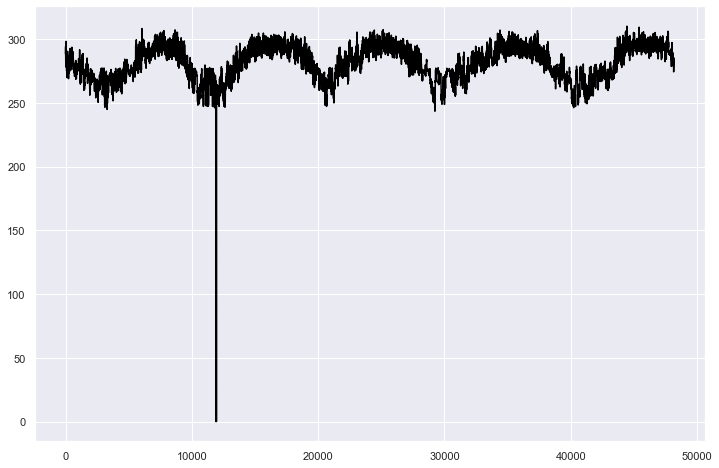

time: 219 ms (started: 2023-04-04 19:39:09 -06:00)


In [90]:
# Plotting temperature over time for entire dataset
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df['temp'], color = "black", label='Temp')

It appears that the temperature follows an expected seasonal pattern except for a smattering of values that are listed as zero. Let's explore where those values are.

In [91]:
# Viewing zero values for the 'temp' column
df[df['temp'] == 0]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
11898,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 03:00:00,361
11899,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 04:00:00,734
11900,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 05:00:00,2557
11901,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 06:00:00,5150
11946,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 03:00:00,291
11947,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 04:00:00,284
11948,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 05:00:00,434
11949,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 06:00:00,739
11950,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 07:00:00,962
11951,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 08:00:00,1670


time: 31 ms (started: 2023-04-04 19:39:09 -06:00)


There are two days in early 2014 that have a few hours with the temperature listed at zero. We know that the 'temp' column is listed in units of Kelvin; zero degrees Kelvin is the lowest limit of the thermodynamic temperature scale where atoms/particles stop moving so it is safe to assume this data is not accurate.

To fix this, we'll take a look at the recorded temperatures immediately before and after the inaccurate temperature data and fill them in with the average value.

In [92]:
# Viewing temperature values immediately before and after the inaccurate data
df['temp'].loc[11897:11902], df['temp'].loc[11945:11952]

(11897    255.93
 11898      0.00
 11899      0.00
 11900      0.00
 11901      0.00
 11902    255.93
 Name: temp, dtype: float64,
 11945    255.37
 11946      0.00
 11947      0.00
 11948      0.00
 11949      0.00
 11950      0.00
 11951      0.00
 11952    255.62
 Name: temp, dtype: float64)

time: 16 ms (started: 2023-04-04 19:39:10 -06:00)


In [93]:
# Setting inaccurate values to be equal to the average of the values immediately before and after
df['temp'].loc[11898:11901] = (df['temp'].loc[11897] + df['temp'].loc[11902]) / 2
df['temp'].loc[11946:11951] = (df['temp'].loc[11945] + df['temp'].loc[11952]) / 2

time: 0 ns (started: 2023-04-04 19:39:10 -06:00)


C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


11897    255.93
11898    255.93
11899    255.93
11900    255.93
11901    255.93
11902    255.93
Name: temp, dtype: float64 11944    255.480
11945    255.370
11946    255.495
11947    255.495
11948    255.495
11949    255.495
11950    255.495
11951    255.495
11952    255.620
Name: temp, dtype: float64


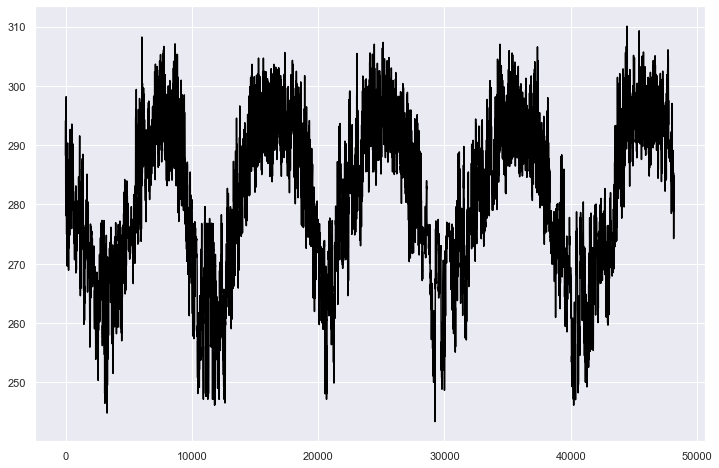

time: 266 ms (started: 2023-04-04 19:39:10 -06:00)


In [94]:
# Checking results
print(df['temp'].loc[11897:11902], df['temp'].loc[11944:11952])

# Plotting again for visual inspection
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df['temp'], color = "black", label='Temp');

The plot looks better now that we've filled in the zero values for the temperature data. It follows the expected seasonal trend of decreasing temperatures as winter approaches and increasing temperatures as summer approaches.

In [95]:
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


time: 32 ms (started: 2023-04-04 19:39:10 -06:00)


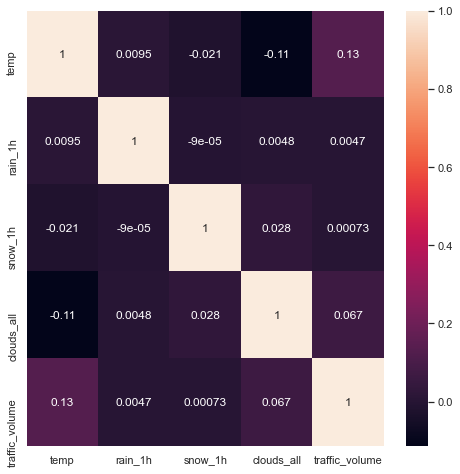

time: 359 ms (started: 2023-04-04 19:39:10 -06:00)


In [96]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True);

In [97]:
# Renaming columns to show units of measurement
df = df.rename(columns={'temp':'temp_k',
                        'rain_1h':'rain_mm',
                        'snow_1h':'snow_mm',
                        'clouds_all':'pct_cloud_cover'})

# Creating column with Fahrenheit values
df['temp_f'] = (df['temp_k'] - 273.15) * 9/5 + 32

time: 15 ms (started: 2023-04-04 19:39:10 -06:00)


In [98]:
df['date_time'] = pd.to_datetime(df['date_time'], infer_datetime_format=True)
df.set_index('date_time', inplace=True)

time: 47 ms (started: 2023-04-04 19:39:10 -06:00)


In [103]:
df

,holiday,temp_k,rain_mm,snow_mm,pct_cloud_cover,weather_main,weather_description,traffic_volume,temp_f
date_time,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,59.234
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,61.178
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,61.574
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,62.564
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,64.382
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,None,283.45,0.0,0.0,75,Clouds,broken clouds,3543,50.540
2018-09-30 20:00:00,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2781,49.298
2018-09-30 21:00:00,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2159,49.244


time: 16 ms (started: 2023-04-04 19:41:46 -06:00)


In [104]:
df_daily = df.resample('D').agg({'rain_mm' : 'sum',
                                 'snow_mm' : 'sum',
                                 'pct_cloud_cover' : 'mean',
                                 'temp_f' : 'mean',
                                 'traffic_volume' : 'mean'})

time: 15 ms (started: 2023-04-04 19:45:07 -06:00)


In [105]:
df_daily

,rain_mm,snow_mm,pct_cloud_cover,temp_f,traffic_volume
date_time,,,,,
2012-10-02,0.00,0.0,29.133333,63.056000,4219.266667
2012-10-03,0.00,0.0,3.850000,55.874300,3317.250000
2012-10-04,0.00,0.0,16.708333,61.173500,3747.458333
2012-10-05,0.00,0.0,75.000000,48.070727,4242.545455
2012-10-06,0.00,0.0,61.652174,40.272957,3256.956522
...,...,...,...,...,...
2018-09-26,0.25,0.0,39.833333,51.522500,3692.791667
2018-09-27,0.50,0.0,61.200000,55.613120,3777.360000
2018-09-28,0.00,0.0,26.250000,47.189000,3854.916667


time: 15 ms (started: 2023-04-04 19:45:09 -06:00)


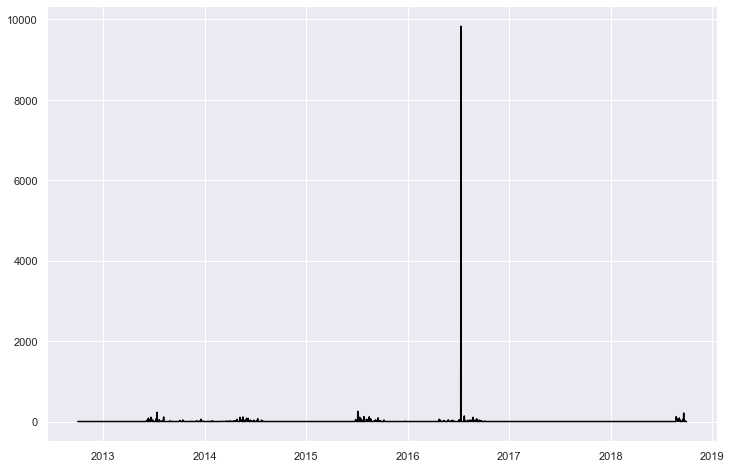

time: 235 ms (started: 2023-04-04 19:46:27 -06:00)


In [107]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df_daily['rain_mm'], color = "black", label='Temp');